Requirements for Transfer Learning
- YoloV3 Weights : https://github.com/patrick013/Object-Detection---Yolov3/blob/master/model/yolov3.weights
- Yolov3 Model Structure : https://github.com/pjreddie/darknet/blob/master/cfg/yolov3.cfg
- COCO Names file : https://github.com/pjreddie/darknet/blob/master/data/coco.names



DATASET
- Image and Lidar Data : https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_10_03_drive_0047/2011_10_03_drive_0047_sync.zip
- Calibration Data : https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_10_03_calib.zip
- FlowChart Link : https://drive.google.com/file/d/1CQ76RS8uKfZc6WuKj2wfLLUWLyZ_IwKM/view?usp=sharing

Flow Chart For this Project:
<img src="FlowChart.png" alt="Chart" style="width:30%; height:20%; display: block; margin: auto; filter: brightness(80%);"/>

# Project Documentation: ADAS Sensor Fusion and Collision Avoidance


## 1. Data Processing

### Data Acquisition
- **Dataset:**  
  We use the publicly available KITTI dataset, which includes synchronized camera images and LiDAR point clouds.
  
- **Data Files:**  
  - **Camera Images:** Stored in the `image_00/data` folder.
  - **LiDAR Point Clouds:** Stored as binary files in the `velodyne_points` folder.
  - **Calibration Files:**  
    - `calib_velo_to_cam.txt`: Contains extrinsic parameters (rotation and translation) to transform LiDAR points from the Velodyne frame to the camera frame.
    - `calib_cam_to_cam.txt`: Contains intrinsic camera parameters, including the projection matrix (`P_rect_02`) and the rectification matrix (`R_rect_02`) for the left camera.
    - `calib_imu_to_velo.txt`: Provides the transformation from the IMU to the LiDAR.

### Preprocessing
- **Camera Images:**  
  Loaded using OpenCV, preprocessed for color conversion and resizing if necessary, then processed by a pre-trained YOLOv3 model for object detection.
  
- **LiDAR Points:**  
  Loaded from binary files, converted to a homogeneous coordinate system, and processed via a transformation pipeline to align with the camera's view.

## 2. Sensor Fusion Techniques

### Projection Pipeline
1. **Rigid Transformation:**  
   LiDAR points are transformed from the Velodyne coordinate system to the camera coordinate system using the 4×4 homogeneous transformation matrix derived from `calib_velo_to_cam.txt`.

2. **Rectification:**  
   The camera coordinates are rectified using the rectification matrix (`R_rect_02`) from `calib_cam_to_cam.txt` to ensure proper alignment with the rectified camera image.

3. **Projection:**  
   The rectified 3D points are projected onto the 2D image plane using the projection matrix (`P_rect_02`).

### Fusion
- **Fusing Detections:**  
  YOLO object detections (bounding boxes) are fused with the projected LiDAR points. For each bounding box, LiDAR points that fall inside are selected, and their average depth is computed (with negative depths clamped to zero). This produces a fused detection containing both visual appearance and depth information.

## 3. Integration of Camera and LiDAR Data

- **Synchronization:**  
  Both camera and LiDAR data are synchronized using frame IDs/timestamps from the KITTI dataset.
  
- **Transformation Chain:**  
  The pipeline involves:
  - Transforming LiDAR points using `Tr_velo_to_cam` (and augmenting to 4×4).
  - Applying `R_rect_02` to rectify the camera coordinates.
  - Projecting the rectified coordinates onto the image using `P_rect_02`.
  
- **Fusion Implementation:**  
  A dedicated fusion function combines YOLO detections with the projected LiDAR data, attaching average depth information to each detection.

## 4. Collision Avoidance Algorithm

### Algorithm Overview
- **Risk Evaluation:**  
  - For each fused detection, the average depth is used to assess the risk level:
    - **High Risk:** If the average depth is ≤ 5 meters.
    - **Moderate Risk:** If the depth is between 5 and 10 meters.
    - **Low Risk:** If the depth is > 10 meters.
  - If no depth is available, the risk is marked as "unknown".
  
- **Alerts and Corrective Actions:**  
  - **Visual Alerts:** Bounding boxes are color-coded (red for high, yellow for moderate, green for low risk) and overlaid on the image.
  - **Audible/Haptic Alerts:** (Not implemented here, but recommended for a complete system.)
  - **Automated Actions:** In a full ADAS system, high risk would trigger automated braking or steering corrections.

### Results
- **Visualization:**  
  The final output image shows the camera view with fused detections, where each bounding box displays the object class, confidence, average depth, and risk level.
  
- **Observations:**  
  - Nearby obstacles are flagged as high risk, prompting immediate corrective measures.
  - Objects at a safe distance are classified as low risk, indicating the system’s capability to distinguish varying levels of threat.
  
- **Performance:**  
  Despite some calibration challenges, the sensor fusion produced robust depth estimates that allowed risk classification.

## 5. Conclusion

This project demonstrates a comprehensive approach to ADAS sensor fusion by integrating camera-based object detection with LiDAR depth estimation. The pipeline includes:
- Data processing and calibration.
- Sensor fusion via rigid transformation, rectification, and projection.
- Collision risk assessment using fused detection depth.
- Generation of visual overlays to indicate risk levels.

The resulting system provides a robust perception and decision-making module that can be further expanded to incorporate additional sensor data, more advanced collision avoidance algorithms, and real-time vehicle control.




Importing Libraries


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import time


Calibration Loader Functions

In [ ]:
def load_calibration(file_path):
    """
    Load calibration data from a text file.
    Each line should be in the format: KEY: value1 value2 ...
    Returns a dictionary with keys and NumPy arrays (or strings for non-numeric values).
    """
    calib = {}
    try:
        with open(file_path, 'r') as f:
            for line in f:
                line = line.strip()
                if not line or ':' not in line:
                    continue
                key, value = line.split(':', 1)
                key = key.strip()
                value = value.strip()
                if key == 'calib_time':
                    calib[key] = value
                else:
                    try:
                        calib[key] = np.array([float(x) for x in value.split()])
                    except ValueError:
                        print(f"Could not convert key {key} to float array.")
        return calib
    except FileNotFoundError:
        print(f"Calibration file not found: {file_path}")
        return None

def get_rigid_transformation(file_path):
    return load_calibration(file_path)


YOLO Object Detection Functions

In [ ]:
# YOLO Object Detection Functions

def load_yolo():
    net = cv2.dnn.readNetFromDarknet("yolov3.cfg", "yolov3.weights")
    with open("coco.names", "r") as f:
        classes = [line.strip() for line in f.readlines()]
    layer_names = net.getLayerNames()
    unconnected = net.getUnconnectedOutLayers()
    if isinstance(unconnected[0], (np.int32, int)):
        output_layers = [layer_names[i - 1] for i in unconnected]
    else:
        output_layers = [layer_names[i[0] - 1] for i in unconnected]
    return net, classes, output_layers

def detect_objects_yolo(image, net, output_layers, conf_threshold=0.5, nms_threshold=0.4):
    height, width = image.shape[:2]
    blob = cv2.dnn.blobFromImage(image, scalefactor=1/255.0, size=(416, 416), swapRB=True, crop=False)
    net.setInput(blob)
    outs = net.forward(output_layers)

    class_ids, confidences, boxes = [], [], []
    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > conf_threshold:
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)
                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    indices = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)
    detections = []
    if len(indices) > 0:
        for i in indices.flatten():
            detections.append((boxes[i], class_ids[i], confidences[i]))
    return detections


LiDAR Data Loading and Visualization

In [ ]:
# LiDAR Data Loading and Visualization

def load_point_cloud(file_path):
    point_cloud = np.fromfile(file_path, dtype=np.float32).reshape(-1, 4)
    return point_cloud

def plot_point_cloud(point_cloud):
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(point_cloud[:, 0], point_cloud[:, 1], point_cloud[:, 2], s=0.5, c=point_cloud[:, 3], cmap='viridis')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.title("LiDAR Point Cloud")
    plt.show()


Projection and Fusion Functions

In [ ]:
# Projection and Fusion Functions

def project_lidar_to_image(point_cloud, calib_velo_to_cam, calib_cam_to_cam):
    """
    Transform LiDAR points to camera coordinates, apply rectification (R_rect_02) and project onto image.
    """
    # Build rigid transform from Velodyne to camera.
    if "Tr_velo_to_cam" in calib_velo_to_cam:
        Tr_velo_to_cam = calib_velo_to_cam["Tr_velo_to_cam"].reshape(3, 4)
    else:
        if "R" in calib_velo_to_cam and "T" in calib_velo_to_cam:
            R = calib_velo_to_cam["R"].reshape(3, 3)
            T = calib_velo_to_cam["T"].reshape(3, 1)
            Tr_velo_to_cam = np.hstack((R, T))
            print("Constructed Tr_velo_to_cam from R and T.")
        else:
            raise ValueError("Missing keys in calib_velo_to_cam to compute Tr_velo_to_cam.")
    # Convert to 4x4 homogeneous matrix.
    Tr_velo_to_cam_hom = np.vstack((Tr_velo_to_cam, [0, 0, 0, 1]))

    # Retrieve rectification matrix R_rect_02.
    if "R_rect_02" in calib_cam_to_cam:
        R_rect_02 = calib_cam_to_cam["R_rect_02"].reshape(3, 3)
    else:
        print("Warning: 'R_rect_02' not found; using identity.")
        R_rect_02 = np.eye(3)

    # Retrieve projection matrix P_rect_02.
    if "P_rect_02" in calib_cam_to_cam:
        P_rect_02 = calib_cam_to_cam["P_rect_02"].reshape(3, 4)
    else:
        raise ValueError("Missing key 'P_rect_02' in calib_cam_to_cam.")

    # Convert LiDAR points to homogeneous coordinates (N x 4).
    ones = np.ones((point_cloud.shape[0], 1))
    points_velo_hom = np.hstack((point_cloud[:, :3], ones))

    # Transform to camera coordinates.
    X_cam_hom = (Tr_velo_to_cam_hom @ points_velo_hom.T).T  # (N, 4)
    X_cam = X_cam_hom[:, :3]  # (N, 3)

    # Apply rectification.
    X_cam_rect = (R_rect_02 @ X_cam.T).T  # (N, 3)

    # Augment rectified coordinates to homogeneous.
    X_cam_rect_hom = np.hstack((X_cam_rect, ones))

    # Project into image plane.
    X_img_hom = (P_rect_02 @ X_cam_rect_hom.T).T  # (N, 3)

    # Convert from homogeneous to 2D.
    X_img_hom[:, 0] /= X_img_hom[:, 2]
    X_img_hom[:, 1] /= X_img_hom[:, 2]

    return X_img_hom  # Returns (u, v, depth)


Fusing Object Detection to Lidar

In [ ]:

def fuse_detections_with_lidar(detections, points_img):
    fused_results = []
    for box, class_id, confidence in detections:
        x, y, w, h = box
        mask = (points_img[:, 0] >= x) & (points_img[:, 0] <= x + w) & \
               (points_img[:, 1] >= y) & (points_img[:, 1] <= y + h)
        lidar_in_box = points_img[mask]
        if lidar_in_box.size > 0:
            # Clamp negative depths to 0 (or take abs() if preferred).
            depths = lidar_in_box[:, 2]
            depths_clamped = np.where(depths < 0, 0, depths)
            avg_depth = np.mean(depths_clamped)
        else:
            avg_depth = None
        fused_results.append({
            "box": box,
            "class_id": class_id,
            "confidence": confidence,
            "avg_depth": avg_depth,
            "lidar_points": lidar_in_box
        })
    return fused_results


def draw_fused_detections(image, fused_detections, classes):
    # We'll display using matplotlib.
    for item in fused_detections:
        box = item["box"]
        class_id = item["class_id"]
        confidence = item["confidence"]
        avg_depth = item["avg_depth"]
        x, y, w, h = box
        label = f"{classes[class_id]}: {confidence:.2f}"
        cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.putText(image, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        if avg_depth is not None:
            cv2.putText(image, f"Depth: {avg_depth:.2f}", (x, y+h+20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
    image_disp = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(12, 8))
    plt.imshow(image_disp)
    plt.title("Fused Detections")
    plt.axis("off")
    plt.show()


Decision Making Functions

In [ ]:
# Decision Making Functions

def decision_making(fused_detections, safe_distance=10.0, high_risk_distance=5.0):
    """
    Evaluate each fused detection's risk based on average depth.
    safe_distance: Depth below which detection is considered moderate risk.
    high_risk_distance: Depth below which detection is considered high risk.
    """
    for detection in fused_detections:
        depth = detection.get("avg_depth", None)
        if depth is None:
            detection["risk"] = "unknown"
        else:
            if depth <= high_risk_distance:
                detection["risk"] = "high"
            elif depth <= safe_distance:
                detection["risk"] = "moderate"
            else:
                detection["risk"] = "low"
    return fused_detections

def draw_decision_overlay(image, fused_detections, classes):
    # Define colors for risk levels: low=green, moderate=yellow, high=red, unknown=blue.
    colors = {
        "low": (0, 255, 0),
        "moderate": (0, 255, 255),
        "high": (0, 0, 255),
        "unknown": (255, 0, 0)
    }
    for detection in fused_detections:
        box = detection["box"]
        risk = detection.get("risk", "unknown")
        color = colors.get(risk, (255, 255, 255))
        x, y, w, h = box
        label = f"{classes[detection['class_id']]}: {detection['confidence']:.2f} | {risk}"
        cv2.rectangle(image, (x, y), (x+w, y+h), color, 2)
        cv2.putText(image, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    image_disp = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(12, 8))
    plt.imshow(image_disp)
    plt.title("Decision Overlay")
    plt.axis("off")
    plt.show()


Main Execution: Integrating YOLO, LiDAR, Calibration, and Decision Making

Detections: [([1, 189, 173, 126], 2, 0.9914174675941467), ([269, 180, 86, 56], 2, 0.9672988653182983), ([333, 185, 135, 82], 2, 0.9622510075569153), ([442, 178, 84, 50], 2, 0.8490252494812012), ([579, 176, 43, 29], 2, 0.670698881149292), ([678, 179, 126, 96], 7, 0.6410703659057617)]


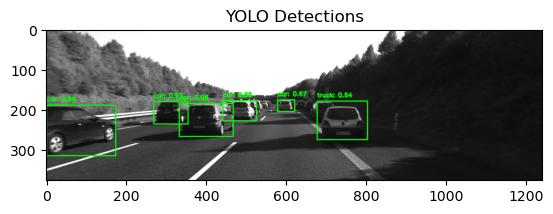

Point Cloud Shape: (116144, 4)


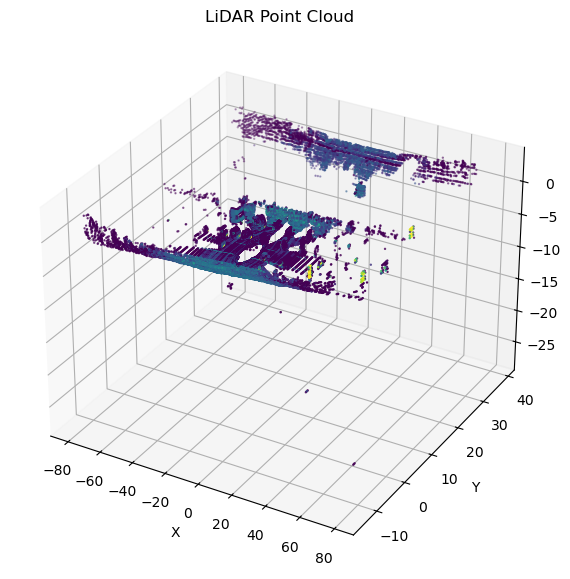

Calibration Data (Velodyne-to-Cam):
calib_time: 15-Mar-2012 11:45:23
R: (9,)
T: (3,)
delta_f: (2,)
delta_c: (2,)
Calibration Data (Cam-to-Cam):
calib_time: 09-Jan-2012 14:00:15
corner_dist: (1,)
S_00: (2,)
K_00: (9,)
D_00: (5,)
R_00: (9,)
T_00: (3,)
S_rect_00: (2,)
R_rect_00: (9,)
P_rect_00: (12,)
S_01: (2,)
K_01: (9,)
D_01: (5,)
R_01: (9,)
T_01: (3,)
S_rect_01: (2,)
R_rect_01: (9,)
P_rect_01: (12,)
S_02: (2,)
K_02: (9,)
D_02: (5,)
R_02: (9,)
T_02: (3,)
S_rect_02: (2,)
R_rect_02: (9,)
P_rect_02: (12,)
S_03: (2,)
K_03: (9,)
D_03: (5,)
R_03: (9,)
T_03: (3,)
S_rect_03: (2,)
R_rect_03: (9,)
P_rect_03: (12,)
Calibration Data (IMU-to-Velo):
calib_time: 25-May-2012 16:47:16
R: (9,)
T: (3,)
Constructed Tr_velo_to_cam from R and T.
Projected LiDAR points shape: (116144, 3)
{'box': [1, 189, 173, 126], 'class_id': 2, 'confidence': 0.9914174675941467, 'avg_depth': 7.915991273171525, 'lidar_points': array([[173.14861771, 225.7813755 , -21.4936185 ],
       [170.12541074, 225.97657208, -21.28743704]

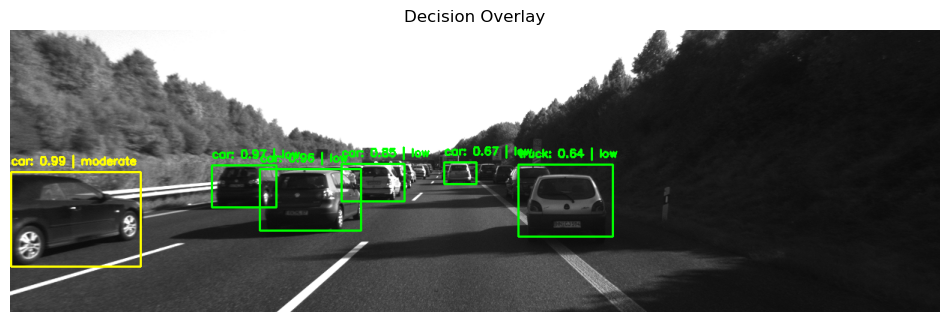

In [ ]:
# Main Execution: Integrating YOLO, LiDAR, Calibration, and Decision Making

def main():
    # Load YOLO model.
    net, classes, output_layers = load_yolo()

    # Set file paths (adjust these paths to your environment).
    image_file_path = 'C:/Users/navee/Documents/Python Scripts/2011_10_03_drive_0047_sync/2011_10_03/2011_10_03_drive_0047_sync/image_00/data/0000000002.png'
    lidar_file_path = 'C:/Users/navee/Documents/Python Scripts/2011_10_03_drive_0047_sync/2011_10_03/2011_10_03_drive_0047_sync/velodyne_points/data/0000000002.bin'
    calib_velo_to_cam_path = 'C:/Users/navee/Documents/Python Scripts/2011_10_03_calib/2011_10_03/calib_velo_to_cam.txt'
    calib_cam_to_cam_path = 'C:/Users/navee/Documents/Python Scripts/2011_10_03_calib/2011_10_03/calib_cam_to_cam.txt'
    calib_imu_to_velo_path = 'C:/Users/navee/Documents/Python Scripts/2011_10_03_calib/2011_10_03/calib_imu_to_velo.txt'

    # Load the camera image.
    image = cv2.imread(image_file_path)
    if image is None:
        print("Error: Image not found.")
        return
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Run YOLO object detection.
    detections = detect_objects_yolo(image_rgb, net, output_layers)
    print("Detections:", detections)
    # Draw YOLO detections on image.
    for box, class_id, confidence in detections:
        x, y, w, h = box
        label = f"{classes[class_id]}: {confidence:.2f}"
        cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.putText(image, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("YOLO Detections")
    plt.show()

    # Load LiDAR point cloud.
    point_cloud = load_point_cloud(lidar_file_path)
    print("Point Cloud Shape:", point_cloud.shape)
    plot_point_cloud(point_cloud)  # Optional visualization

    # Load calibration data.
    calib_velo_to_cam = load_calibration(calib_velo_to_cam_path)
    calib_cam_to_cam = load_calibration(calib_cam_to_cam_path)
    calib_imu_to_velo = load_calibration(calib_imu_to_velo_path)
    print("Calibration Data Loaded.")
    # Project LiDAR points onto the image plane.
    points_img = project_lidar_to_image(point_cloud, calib_velo_to_cam, calib_cam_to_cam)
    print("Projected LiDAR points shape:", points_img.shape)

    # Fuse YOLO detections with projected LiDAR points.
    fused_detections = fuse_detections_with_lidar(detections, points_img)
    for result in fused_detections:
        print(result)

    # Decision making: classify risk based on depth.
    # Here we use safe_distance (e.g., 10m) and high_risk_distance (e.g., 5m).
    fused_detections = decision_making(fused_detections, safe_distance=10.0, high_risk_distance=5.0)
    for det in fused_detections:
        print(f"Detection: {det['box']}, Depth: {det['avg_depth']}, Risk: {det.get('risk')}")

    # Draw overlay with decision (risk) information.
    draw_decision_overlay(image_rgb.copy(), fused_detections, classes)


if __name__ == "__main__":
    main()
